# DyNaVoiCeR II - Pulse Generation

This python notebook is intended as a study of some popular glottal modelling techniques such as the LF model and rosenberg.

Also, individual pulse generation is done at the end using the recorded fourier magnitudes and normalized delays (as presented in ) in order to obtain the glottal flow derivative

In [6]:
# libraries here

import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import lfilter, spectrogram
from scipy.io import loadmat, wavfile
from IPython.display import Audio

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

### L-F Model Formulas

The Liljencrants-Fant model is proposed as a simpler model than the Rosenberg-C one. It is represented by 5 parameters:

- $E_e$: amplitude at the minimum of the glottal flow derivative waveform
- $T_0$: fundamental period
- $T_e$: instant of maximum excitation
- $T_p$: instant of the maximum glottal flow
- $T_a$: time constant of the return phase 

$$

E(t) = 
\begin{cases}
    - E_e e^{a(t-T_e)}\frac{\sin{\pi t/T_p}}{\sin{\pi(T_e/T_p)}} & 0 \le t \le T_e \\
    - \frac{E_e}{\epsilon T_a} (e^{-\epsilon(t-T_0)} - e^{-\epsilon(T_0- T_e)}) & T_e \le t \le T_0

\end{cases}
$$


Although this requires to solve two implicit equations in order to solve for $\epsilon$ first and then $a$:

$$\epsilon T_a = 1 - e^{-\epsilon(T_0 - T_e)}$$

$$\frac{1}{a^2+ (\frac{\pi}{T_p})^2} \left(e^{aT_e}\frac{\pi/T_p}{\sin(\pi T_e/T_p)} + a - \frac{\pi}{T_p}\cot{\pi T_e/T_p}\right) = \frac{T_0-T_e}{e^{\epsilon(T_0 - T_e)} - 1} - \frac{1}{\epsilon}$$

In [2]:
import sympy as sp

#solve for epsilon
epsilon = sp.symbols('epsilon')
Ta = sp.symbols('Ta')
Te = sp.symbols('Te')
To = sp.symbols('To')

equation = epsilon * Ta - (1 - sp.exp(-epsilon * (To - Te)))

try:
    solution = sp.solve(equation.subs({To: 8e-3, Ta: 5e-3, Te: 5e-3}), epsilon)

    non_zero_solution = [value for value in solution if value != 0]
    print(non_zero_solution)

except:
    print("No solution found")

# solve for a
a, epsilon, T_p, T_e, T_0 = sp.symbols('a epsilon T_p T_e T_0')

# Define the equation
equation = (1/(a**2 + (sp.pi/T_p)**2) * (sp.exp(a*T_e)*((sp.pi/T_p)/sp.sin(sp.pi*T_e/T_p)) + a - (sp.pi/T_p)*sp.cot(sp.pi*T_e/T_p))) - ((T_0-T_e)/(sp.exp(epsilon*(T_0 - T_e)) - 1) - 1/epsilon)

# Example values for epsilon, T_p, T_e, and T_0
epsilon_val = -315.801627205051
T_p_val = 8e-3
T_e_val = 5e-3
T_0_val = 8e-3

# Substitute values and solve for a
try:
    numeric_solution_a = sp.solve(equation.subs({epsilon: epsilon_val, T_p: T_p_val, T_e: T_e_val, T_0: T_0_val}), a)
    
    non_zero_solution = [value for value in numeric_solution_a if value != 0]
    print(non_zero_solution)
except:
    print("No solution found")

No solution found
No solution found


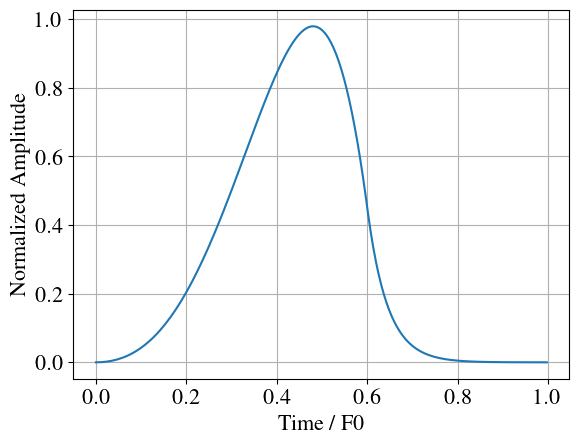

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def v_glotlf(d=0, t=None, p=None):
    if p is None:
        p = np.array([0.6, 0.1, 0.2])
    elif len(p) < 3:
        default_p = np.array([0.6, 0.1, 0.2])
        p = np.concatenate([p, default_p[len(p):]])

    if t is None:
        tt = np.linspace(0, 0.99, 100)
    else:
        tt = t - np.floor(t)  # only interested in the fractional part of t

    te = p[0]
    mtc = te - 1
    e0 = 1
    wa = np.pi / (te * (1 - p[2]))
    a = -np.log(-p[1] * np.sin(wa * te)) / te
    inta = e0 * ((wa / np.tan(wa * te) - a) / p[1] + wa) / (a**2 + wa**2)

    rb0 = p[1] * inta
    rb = rb0
    for _ in range(4):
        kk = 1 - np.exp(mtc / rb)
        err = rb + mtc * (1 / kk - 1) - rb0
        derr = 1 - (1 - kk) * (mtc / rb / kk)**2
        rb = rb - err / derr

    e1 = 1 / (p[1] * (1 - np.exp(mtc / rb)))
    ta = tt < te
    tb = ~ta

    if d == 0:
        u = np.zeros_like(tt)
        u[ta] = e0 * (np.exp(a * tt[ta]) * (a * np.sin(wa * tt[ta]) - wa * np.cos(wa * tt[ta])) + wa) / (a**2 + wa**2)
        u[tb] = e1 * (np.exp(mtc / rb) * (tt[tb] - 1 - rb) + np.exp((te - tt[tb]) / rb) * rb)
    elif d == 1:
        u = np.zeros_like(tt)
        u[ta] = e0 * np.exp(a * tt[ta]) * np.sin(wa * tt[ta])
        u[tb] = e1 * (np.exp(mtc / rb) - np.exp((te - tt[tb]) / rb))
    elif d == 2:
        u = np.zeros_like(tt)
        u[ta] = e0 * np.exp(a * tt[ta]) * (a * np.sin(wa * tt[ta]) + wa * np.cos(wa * tt[ta]))
        u[tb] = e1 * np.exp((te - tt[tb]) / rb) / rb
    else:
        raise ValueError('Derivative must be 0, 1, or 2')

    return u

# Example of usage:
f0 = 130  # frequency in Hz
t = np.arange(0, 1/f0, 1/22050)  # time axis
u = v_glotlf(1, t*f0)  # compute the waveform using default parameters
u0 = v_glotlf(0, t*f0)  # compute the waveform using default parameters
u /= np.max(np.abs(u))

fig, ax = plt.subplots()
ax.grid(True)
ax.plot(t*f0, u0)
ax.set_ylabel("Normalized Amplitude")
ax.set_xlabel("Time / F0")

plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter2/lfFlow.pdf', format='pdf', dpi = 300, bbox_inches='tight')

def lfPulse(F0, Fs, length, gain=0.95):
    t = np.arange(0, length/Fs, 1/Fs)
    u = v_glotlf(1, t*f0)  # compute the waveform using default parameters

    u = gain * u / np.max(np.abs(u))

    return u



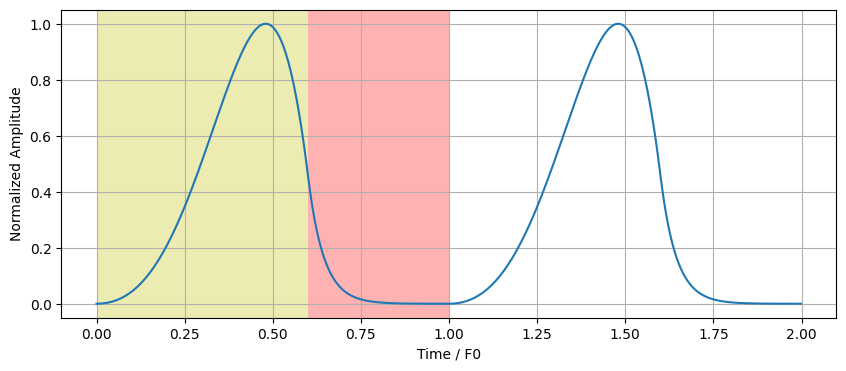

In [ ]:
f0 = 130  # frequency in Hz
t = np.arange(0, 2/f0, 1/22050)  # time axis
u = v_glotlf(0, t*f0)  # compute the waveform using default parameters
u /= np.max(np.abs(u))

plt.figure(figsize=(10, 4))
plt.grid(True)
plt.plot(t*f0, u)
plt.ylabel("Normalized Amplitude")
plt.xlabel("Time / F0")
plt.axvspan(0, 0.6, color='y', alpha=0.3, lw=0)
plt.axvspan(0.6, 1, color='r', alpha=0.3, lw=0)

Later on we're going to need the fourier expantion of this glottal flow derivative signal, in order to synthesize it in the STM32 environment. We can achieve this by doing the following:

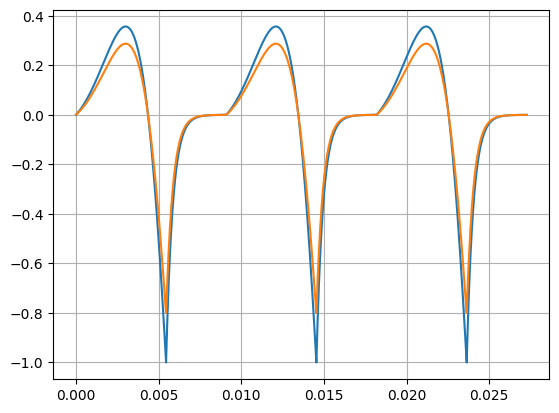

Magnitude:  [1.48742837e-09 3.13912393e+07 2.55096611e+07]
Phase:  [ 3.14159265  1.17110793 -2.12536015]


In [ ]:
# we can compute the Fourier series of the waveform
# assuming that it is periodic with period 1/f0
# let's assume a discrete approximation of the series
# and that the signal func is a single period 
def fourierSeries(func, f0, t, nHarm):
    t0 = 1 / f0 # function period 

    a = np.zeros(nHarm)
    b = np.zeros(nHarm)

    a[0] = np.sum(func) / len(func) # mean

    for i in range(1, nHarm):
        a[i] = 2 / t0 * np.sum(func * np.cos(2*np.pi * f0 * i * t))
        b[i] = 2 / t0 * np.sum(func * np.sin(2*np.pi * f0 * i * t))

    mag = np.sqrt(a**2 + b**2)
    phase = np.arctan2(b, a)
    #phase = np.arctan(b/a)

    return mag, phase

f0 = 110  # frequency in Hz
t = np.linspace(0, 3/f0, 100000)  # time axis
u = v_glotlf(1, t * f0)  # compute the waveform using default parameters

fig, ax = plt.subplots()
#u = u / np.max(np.abs(u))
plt.plot(t, u / (np.max(np.abs(u))))

nHarm = 200
mag, phase = fourierSeries(u, f0, t, nHarm)

func = np.zeros(len(t))
for i in range(1, nHarm):
    func += mag[i]*np.cos(2*np.pi * t * i * f0 - phase[i])

# normalize the function
func = func / np.max(np.abs(func)) * 0.8

ax.plot(t, func)
plt.grid(True)
plt.show()

print("Magnitude: ", mag[0:3])
print("Phase: ", phase[0:3])

Instead of utilizing phase and storing these values in memory, we can use the *normalized relative delay*, which has been shown to constitute a holistic feature of speech carrying idiosyncratic information.

The NRDs are related to the instantaneous phase $\phi_k$ and time shift $n_k$ as shown in the following equations:

$$NRD_l = \frac{n_l - n_0}{T/l} = \frac{\phi_l - l \phi_0}{2\pi}$$

Where l is the harmonic index...

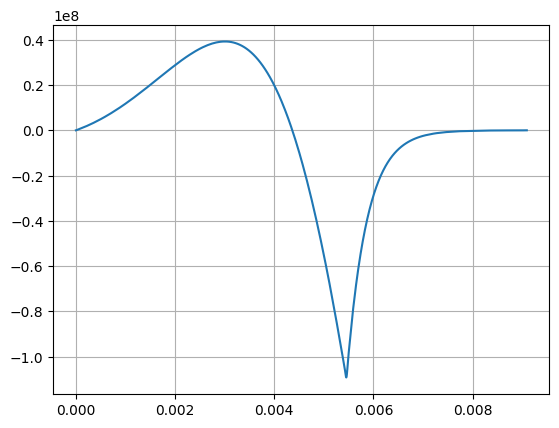

In [ ]:
# Convert phase to NRD (normalized relative delay)
# TODO: this implementation is not correct
# as the nrd should be in the range of [0, 1]
nrd = - (phase - np.pi/2) / (2 * np.pi)
nrd = np.mod(nrd, 1) # wrap the nrds (this is also not correct) 

#for l in range(len(phase)):
#    nrd[l] = (phase[l] - (l+1) * phase[0])/(2*np.pi)

phi = 2 * np.pi * nrd # phase in radians from nrd

t = np.linspace(0, 1/f0, 10000)
wave = np.zeros(len(t))

for i in range(len(mag)):
    wave += mag[i] * np.sin(i*2*np.pi*f0*t + phi[i])

plt.plot(t, wave)
plt.grid(True)

# export the magnitude and nrd coefficients in a C compatible format (array)
magStr = "{" + ", ".join([str(round(x, 4)) for x in mag[1:]]) + "};"
nrdStr = "{" + ", ".join([str(round(x, 4)) for x in nrd[1:]]) + "};"

# write the coefficients to a file
with open("lfCoeffs.h", "w") as f:
    f.write("float32_t mag[] = " + magStr + "\n")
    f.write("float32_t nrd[] = " + nrdStr + "\n")

### Rosenberg Model

Lifted from *The spectrum of glottal flow models*

The Rosenberg C model is a trigonometric model, defined by the following 4 parameters:

- $A$: Amplitude
- $T_0$: fundamental period
- $T_p$: maximum time of the glottal flow waveform
- $T_n$: time interval between maximum of the glottal flow waveform and the GCI (thus $T_p + T_n$ is the CGI)

The glottal flow derivative is given by the following piece wise function:

$$
U'(t)=
\begin{cases}

    \frac{\pi A}{2T_p} \sin{\pi \frac{t}{T_p}} & 0 \le t \le T_p \\
    -\frac{\pi A}{2T_n} \sin{\frac{\pi}{2} \frac{t-T_p}{T_n}} & T_p \le t \le T_p + T_n \\
    0 & T_p + T_n \le t \le T_0

\end{cases}
$$

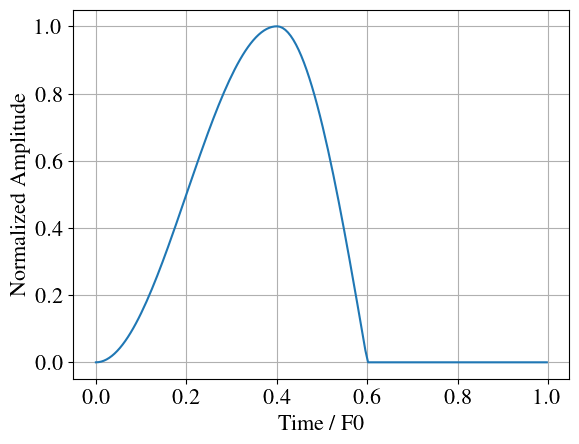

In [13]:
""" def rosenbergSynth(time, A, T0, Tp, Tn, Fs):

    Ts = 1/Fs # sampling period
    t = np.arange(0, time, Ts) # timescale

    out = np.zeros(len(t))

    # opening phase
    idx = (t >= 0) & (t <= Tp)
    out[idx] = np.pi * A/(2*Tp) * np.sin(np.pi * t[idx]/Tp)

    #closing phase
    idx = (t >= Tp) & (t <= (Tp + Tn))
    out[idx] = -np.pi * A/(2*Tp) * np.sin(np.pi/2 * (t[idx]-Tp)/Tn)

    return out """

def v_glotros(d, t=None, p=None):
    if t is None:
        tt = np.linspace(0, 0.99, 100)
    else:
        tt = np.mod(t, 1)
        
    if p is None:
        p = np.array([0.6, 0.5])
    elif len(p) < 2:
        p = np.concatenate([p, np.array([0.6, 0.5][len(p):])])

    pp = p[0] / (1 + p[1])
    ta = tt < pp
    tb = (tt < p[0]) & ~ta

    wa = np.pi / pp
    wb = 0.5 * np.pi / (p[0] - pp)
    fb = wb * pp
    
    u = np.zeros_like(tt)
    
    if d == 0:
        u[ta] = 0.5 * (1 - np.cos(wa * tt[ta]))
        u[tb] = np.cos(wb * tt[tb] - fb)
    elif d == 1:
        u[ta] = 0.5 * wa * np.sin(wa * tt[ta])
        u[tb] = -wb * np.sin(wb * tt[tb] - fb)
    elif d == 2:
        u[ta] = 0.5 * wa**2 * np.cos(wa * tt[ta])
        u[tb] = -wb**2 * np.cos(wb * tt[tb] - fb)
    else:
        raise ValueError('Derivative must be 0, 1, or 2')
    
    return u

# Example usage:
# Example of usage:
f0 = 130  # frequency in Hz
t = np.arange(0, 1/f0, 1/22050)  # time axis
u = v_glotros(0, t*f0)
u /= np.max(np.abs(u))

fig, ax = plt.subplots()
ax.grid(True)
ax.plot(t*f0, u)
ax.set_ylabel("Normalized Amplitude")
ax.set_xlabel("Time / F0")
plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter2/rosenbergFlow.pdf', format='pdf', dpi = 300, bbox_inches='tight')

### Robust L-F synthesis - single pulse

This of course is not an ideal way to model the pulses, as there are several parameters to tweak in order to change the waveform characteristics. In *a holistc glottal phase-related feature* AJF and JMT give an example on how the LF derivatice can be synthesized using original experimental data using the magnitudes and NRDs of the measured signal.

$$
    g_f(t) = \sum_{l=1}^L \frac{LFmag_l}{l} sin(\frac{2\pi}{T}lt + 2\pi + LFNRD_l -\frac{\pi}{2})
$$



This example uses the first 20 harmonics of the experimental glottal flow derivative data. Although it has been shown that using the NRD first-order approximation shows minimal error *(as NRD is an holist vocal features which carries idiosyncratic information, idk if this is indeed the fact)*


[127.75712729 125.96045048 120.63637574 116.86505272 113.8789857
 110.78919591 108.75612537 106.50589634 104.56773675 103.15588621
 101.2940813  100.1553461   98.79837372  97.49449253  96.69426387
  95.32664017  94.64305041  93.70830887  92.72693877  92.21235364
  91.19303829  90.74026643  90.05456809  89.24164179  89.00770799
  88.16411508  87.86905499  87.36129279  86.73759912  86.62027454
  85.91529439  85.73638821  85.37634018  84.8546795   84.86114343
  84.25057655  84.19294799  83.92136407  83.50342335  83.60809649
  83.10197466  83.12072764  82.93968198  82.62918072  82.81524698
  82.38319663  82.49187896  82.40771467  82.15257198  82.4169382 ]


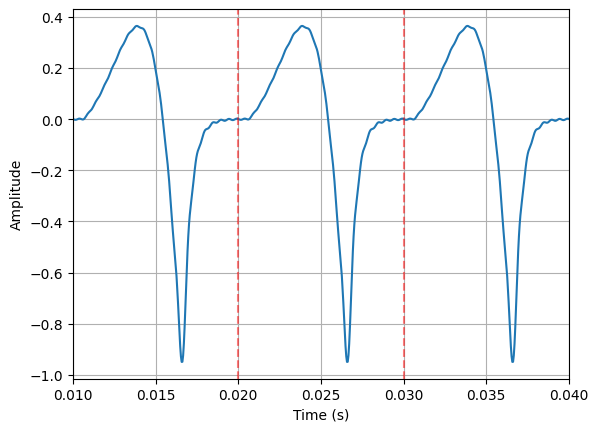

In [ ]:
Fs = 22500    # (Hz) sampling frequency
Ts = 1/Fs       # (s) sampling period
F0 = 100.0      # (Hz) fundamental frequency

# Generate time scale
t = np.arange(0, 4, Ts) # 4s

# Load delay coefficients and magnitudes from matlab files
mat = loadmat('LFNRD.mat')
LFnrd = mat["LFNRD"][0]
mat = loadmat('LFmag.mat')
LFmag = mat["LFmag"][0]
print(LFmag)

tmpmag = np.power(10, LFmag/20) # dB to lin

# synthesize L-F derivative and L-F glottal flow using 
# original experimental data (20 harmonics)
NRDmodel = LFnrd
NRDmodel = np.mod(NRDmodel, 1) # wrap the nrds

# synthesize the derivative of the L-F glottal flow model
dgf = np.zeros(len(t))
L = 20
for k in range(L):
    dgf = dgf + tmpmag[k]*np.sin((k+1)*2*np.pi*F0*t + 2*np.pi*NRDmodel[k]) # multiply frequency component by (k+1) important!

# normalize output signal amplitude
dgf = dgf/max(abs(dgf)) *0.95

# plot the thing
fig, ax = plt.subplots()
ax.plot(t, dgf)
ax.set_xlim(1/F0, 4/F0) # show 3 wave periods
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time (s)')

# add vertical lines to represent fundamental period/frequency
ax.axvline(x=2/F0, color = 'r', linestyle='--', alpha = 0.5)
ax.axvline(x=3/F0, color = 'r', linestyle='--', alpha = 0.5)

plt.grid(True)
plt.show()

# write to wav file
wavfile.write('output.wav', Fs, dgf)

Then a simple function can be made in order to generate a single glottal pulse. In *A holistic glottal phase-related feature*, they do a first order approximation of the NRD model obtained experimentally

In [ ]:
def singleLFpulse(F0, Fs, mag, nrd, gain = 0.95):
    T = 1/F0 # fundamental period
    t = np.arange(0, T, 1/Fs)
    
    L = len(nrd) # number of harmonics to use (how is nrd lower than mag in this case?)
    dgf = np.zeros(len(t)) # output glottal flow derivative

    for i in range(L):
        dgf = dgf + mag[i] * np.sin((i+1)*2*np.pi*F0*t + 2*np.pi*nrd[i])

    dgf = dgf/max(abs(dgf)) * gain # normalize output signal amplitude

    return dgf

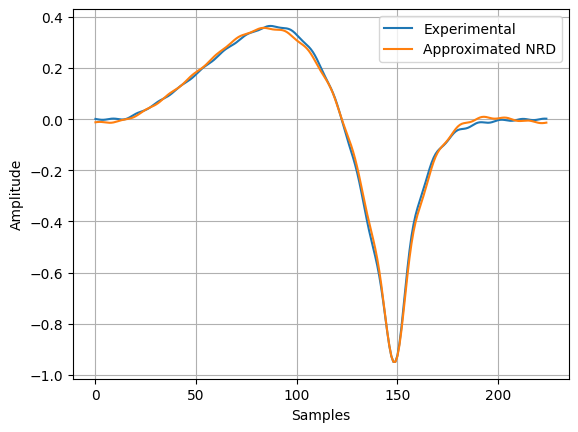

MSE:  0.0001937274602250142


In [ ]:
pulse1 = singleLFpulse(F0, Fs, tmpmag, NRDmodel)

# Use approximated NRD feature model
plf = [0.335465, -0.207431] # don't forget the comma
nrd_approx = np.polyval(plf, np.arange(2, len(NRDmodel)))
nrd_approx = np.insert(nrd_approx, 0, 0.0)
nrd_approx = np.mod(nrd_approx, 1)
pulse2 = singleLFpulse(F0, Fs, tmpmag, nrd_approx)

fig, ax = plt.subplots()
ax.plot(pulse1, label='Experimental')
ax.plot(pulse2, label='Approximated NRD')
ax.grid(True)
ax.set_xlabel("Samples")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()

# calculate error
mse = np.sum((pulse1 - pulse2)**2)/len(pulse1)
print("MSE: ", mse)

### Pulse concatenation

Then it is simple enough to generate individual pulses and concatenate them into a complete signal. We can define a function for now that represents the $F_0$ contour of the pulses, in this case these follow a ADSR pattern from 100 to 250 Hz. 

> ***Q.:*** Pulse segments should also be windowed no?? *(i gonna do it, just watch me)*

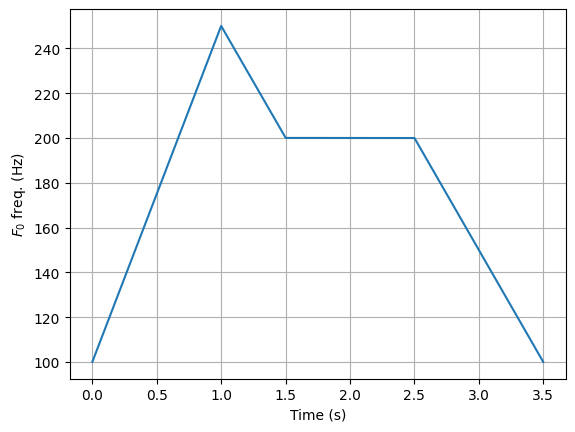

In [ ]:
Fs = 22500

# generate a ADSR envelope for the F_0 contour
attack = np.linspace(100, 250, 1*Fs)
decay = np.linspace(250, 200, int(0.5*Fs))
sustain = np.full(Fs, 200)
release = np.linspace(200, 100, 1*Fs)

contour = np.concatenate((attack, decay, sustain, release))

# Add a smooth, sine-wave-based modulation to simulate vibrato
modulation = 3 * np.sin(2 * np.pi * 4 * np.arange(0, 3.5, 1/Fs))

#contour = contour + modulation

fig, ax = plt.subplots()
ax.plot(np.arange(0, 3.5, 1/Fs), contour)
ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_ylabel("$F_0$ freq. (Hz)")
plt.show()

# start generating glottal impulses
pos = 0
pulses = np.array([])
while pos < len(contour):
    freq = contour[pos]
    p = singleLFpulse(freq, Fs, tmpmag, NRDmodel)
    #p = apply_window(p) # window each pulse
    
    pulses = np.concatenate([pulses, p])
    pos += len(p)

# write to wav file
wavfile.write('output.wav', Fs, pulses)

$$ f_0 (x) = F0 (1 - \alpha x) \exp(-\beta x) \sin(\gamma x - \theta x) $$

- $F_0$ is the average fundamental frequency.
- $x$ is the frame number after the voicing onset.
- $\alpha, \beta, \gamma, $ and $ \theta $ are constants that will shape the contour.

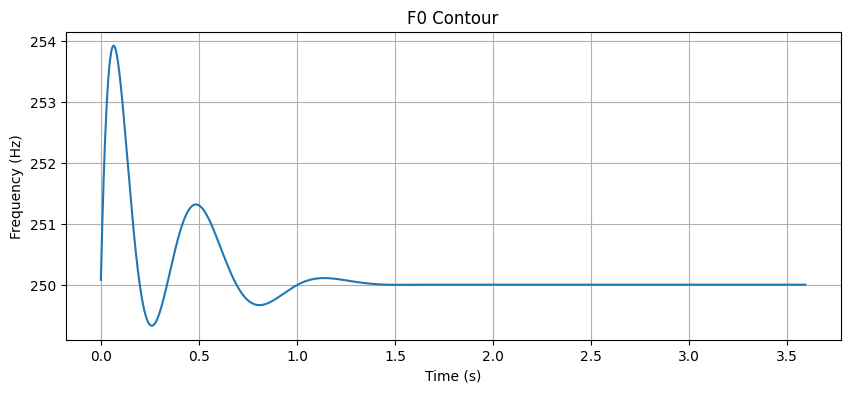

In [ ]:
buffer_size = 512; Fs = 22500
length = 70 # length in frames

Ts = 1/Fs
F0 = 250
alpha = 0.7  # Arbitrary chosen
beta = 0.8  # Arbitrary chosen
gamma = 5 * 2 * np.pi / 25  # 4 full sine wave cycle every 25 frames
theta = 0.1

# Define the function for the F0 contour
def F0_contour(x, F0, alpha, beta, gamma, theta):
    x = x*buffer_size/length # use with the time setting only

    return F0 * (1 - alpha * x) * np.exp(-beta * x) * np.sin(gamma * x) - theta*x + F0

# Generate x values corresponding to frame numbers
time = np.arange(0, length*buffer_size*Ts, Ts)
#frames = np.arange(0, 25*buffer_size*Ts, Ts)

# Calculate the F0 contour
contour = F0_contour(time, F0, alpha, beta, gamma, theta)
contour = (contour - contour[-1])*0.06 + F0 # normalize this using the last frequency value

# extend the f0 contour with the last frequency value
contour = np.concatenate([contour, np.full(2 * Fs, contour[-1])])

# add a vibrato effect
vibrato = 4 # Hz
t = np.arange(0, len(contour)/Fs, 1/Fs)
modulation = 1 * np.sin(2 * np.pi * vibrato * t)
#contour = contour + modulation


# Plot the F0 contour
plt.figure(figsize=(10, 4))
plt.plot(np.arange(0, len(contour)/Fs, 1/Fs), contour)
plt.title('F0 Contour')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.grid(True)
plt.show()

# start generating glottal impulses
pos = 0
pulses = np.array([])
while pos < len(contour):
    freq = contour[pos]
    p = singleLFpulse(freq, Fs, tmpmag, NRDmodel)
    #p = apply_window(p) # window each pulse
    
    pulses = np.concatenate([pulses, p])
    pos += len(p)

wavfile.write('output.wav', Fs, pulses)
Audio(pulses, rate = Fs)

### Exporting the envelope

Since we don't actually need to have every single $F_0$ value, we can just *sample* these as required.

In [ ]:
i = 0

new_contour = np.array([])

# this is somehow wrong as a lower sampling frequency leads to more envelope frequencies being sampled????

# sample the contour frequencies as needed
while i < len(contour):
    #print(contour[i])
    new_contour = np.concatenate([new_contour, contour[i].reshape(1)])
    f = contour[i]
    sampling_periods = int(Fs/f) # number of samples per period
    i += sampling_periods

# make it C friendly
output = "{" + ", ".join([str(round(x, 3)) for x in new_contour]) + "};"
print(output)

# write to file
with open("contour.h", "w") as f:
    f.write("float32_t contour[] = " + output + "\n")

{250.078, 250.6, 251.076, 251.509, 251.899, 252.248, 252.559, 252.833, 253.07, 253.274, 253.446, 253.589, 253.705, 253.794, 253.859, 253.901, 253.922, 253.922, 253.904, 253.869, 253.818, 253.752, 253.674, 253.584, 253.483, 253.373, 253.254, 253.128, 252.997, 252.859, 252.718, 252.572, 252.423, 252.272, 252.12, 251.968, 251.817, 251.667, 251.518, 251.372, 251.229, 251.089, 250.953, 250.82, 250.693, 250.57, 250.452, 250.339, 250.232, 250.131, 250.036, 249.946, 249.862, 249.784, 249.712, 249.647, 249.588, 249.535, 249.488, 249.448, 249.413, 249.385, 249.362, 249.345, 249.333, 249.327, 249.326, 249.33, 249.338, 249.351, 249.369, 249.39, 249.416, 249.445, 249.477, 249.513, 249.551, 249.593, 249.636, 249.682, 249.73, 249.78, 249.832, 249.884, 249.938, 249.993, 250.048, 250.103, 250.159, 250.215, 250.27, 250.326, 250.381, 250.435, 250.489, 250.541, 250.593, 250.644, 250.693, 250.741, 250.788, 250.833, 250.876, 250.918, 250.958, 250.995, 251.031, 251.065, 251.097, 251.127, 251.155, 251.18, 251

#### Use this cell to play the audio file!

VLC media player is required, as ```cvlc``` is used (no more lol)

In [ ]:
## Use this to play the audio file!
import subprocess
import time
from IPython.display import Audio

def playAudio(file, size):
    command = "cvlc " + file
    process = subprocess.Popen(command, shell=True)

    time.sleep(size)

    try:
        process.kill()
        print("Process was killed")
    except OSError:
        pass  # Process is already terminated

#playAudio('output.wav', len(pulses)/Fs + 0.2)

Audio('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/src/pythonDemos/output.wav')

We can then plot the spectrogram and see the wave frequency changing along with the harmonics

Text(0, 0.5, 'Frequency [Hz]')

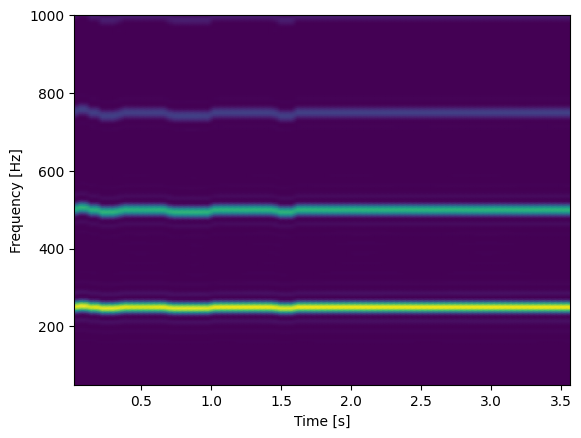

In [ ]:
f, t, Sxx = spectrogram(pulses, Fs, nperseg=1024, nfft=4096)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylim([50, 1000])
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

it would be fun to experiment with fundamental pitch detection using librosa's methods

https://librosa.org/doc/main/generated/librosa.pyin.html#librosa.pyin